In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
import random
random.seed(42)
np.random.seed(42)

In [3]:
# with open("../ressources/dpo_ft_model_train_2024-12-20_s17_n600_b/dataset.pickle", "rb") as file:
# #with open("../ressources/dpo_rl_01_24-12-24_s17_n600_e10_r100/dataset.pickle", "rb") as file:
# #with open("../ressources/automode_evaluated_concat_s14s15s16_n300_24-12-18.pickle", "rb") as file:
# #with open("../ressources/llm_evaluated_concat_s14n600_s15n600_train_2024-12-12_16.pickle", "rb") as file:
# #with open("testdata.pkl", "rb") as file:
#     original_df = pickle.load(file)

In [4]:
# original_df

In [5]:
# df = original_df
# df["type"] = df["parameters"].map(lambda x: type(x.objective_params).__name__)

Training Losses: [0.7459, 0.7357, 0.7172, 0.7065, 0.6167, 0.8089, 0.7925, 0.5683, 0.8113, 0.6374, 0.5639, 0.6258, 0.6501, 0.7087, 0.5723, 0.615, 0.6613, 0.5201, 0.5875, 0.263, 0.6714, 0.8868, 0.4993, 0.5416, 0.5534, 0.5306]
Training Epochs: [0.11363636363636363, 0.22727272727272727, 0.3409090909090909, 0.45454545454545453, 0.5681818181818182, 0.6818181818181818, 0.7954545454545454, 0.9090909090909091, 1.0227272727272727, 1.1363636363636362, 1.25, 1.3636363636363638, 1.4772727272727273, 1.5909090909090908, 1.7045454545454546, 1.8181818181818183, 1.9318181818181817, 2.0454545454545454, 2.159090909090909, 2.2727272727272725, 2.3863636363636362, 2.5, 2.6136363636363638, 2.7272727272727275, 2.840909090909091, 2.9545454545454546]
Evaluation Losses: []
Evaluation Epochs: []


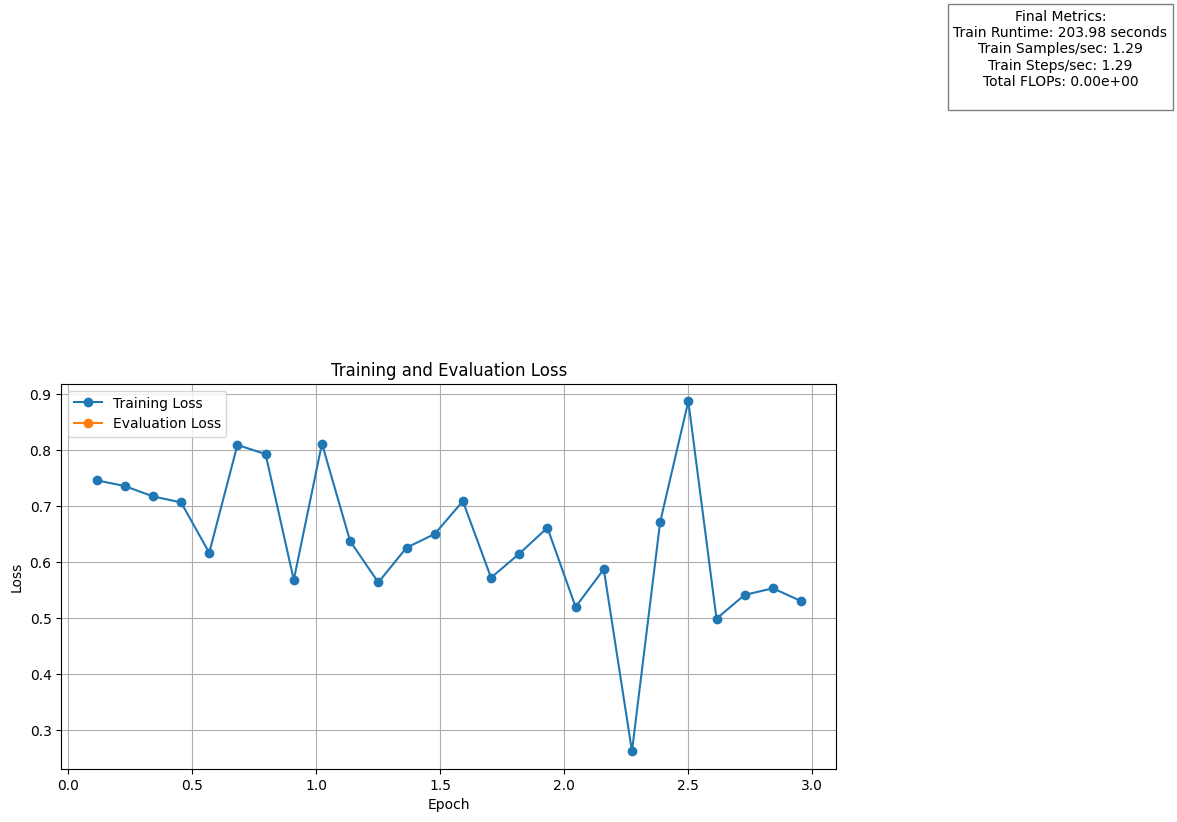

In [6]:
# %%
EXP_NAME="../scripts/dpo_rl_model"
import pickle
with open(EXP_NAME+"/loss_history.pkl", 'rb') as file:
    loss_history = pickle.load(file)
# %%
# Initialize lists to store losses and epochs
train_losses = []
eval_losses = []
train_epochs = []
eval_epochs = []
final_metrics = {}
# Extract losses and corresponding epochs
import matplotlib.pyplot as plt
for entry in loss_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_epochs.append(entry['epoch'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_epochs.append(entry['epoch'])
    if 'train_runtime' in entry:
        final_metrics['train_runtime'] = entry['train_runtime']
        final_metrics['train_samples_per_second'] = entry['train_samples_per_second']
        final_metrics['train_steps_per_second'] = entry['train_steps_per_second']
        final_metrics['total_flos'] = entry['total_flos']


# Ensure that the lengths of train_losses and eval_losses match their respective epochs
print("Training Losses:", train_losses)
print("Training Epochs:", train_epochs)
print("Evaluation Losses:", eval_losses)
print("Evaluation Epochs:", eval_epochs)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.plot(train_epochs, train_losses, label='Training Loss', marker='o')

# Plotting evaluation loss
plt.plot(eval_epochs, eval_losses, label='Evaluation Loss', marker='o')

plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.text(4, 1.5, f"Final Metrics:\n"
                    f"Train Runtime: {final_metrics['train_runtime']:.2f} seconds\n"
                    f"Train Samples/sec: {final_metrics['train_samples_per_second']:.2f}\n"
                    f"Train Steps/sec: {final_metrics['train_steps_per_second']:.2f}\n"
                    f"Total FLOPs: {final_metrics['total_flos']:.2e}\n"             ,
         fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

#plt.yscale("log")
plt.legend()
plt.grid()
plt.savefig(EXP_NAME+'/training_evaluation_loss_plot.png', bbox_inches='tight')

In [7]:
from pipeline.pipeline import MLPipeline


mlp = MLPipeline()
mlp.prepare_model()
#mlp.prepare_model_from_path("../scripts/dpo_ft_model/")
mlp.load_dpo_trained_model("../scripts/dpo_ft_model/", "train_adapt")

def txt_prompt(llmin, llmout, tokenizer):
        #f"\nNUMNODES={int(len(llmout.split(' '))/2.0)}\n"+
        # f"\nsyntax example: {stx}\n"
        # Specify the tree inside |BTSTART|<TREE>|BTEND| by starting the tree with --nroot.
        messages = [
            {"role": "user", "content": llmin+"\nGenerate the behavior tree that achieves the objective of this mission."},
            {"role": "assistant", "content": llmout},
        ]

        text = tokenizer.apply_chat_template(messages, tokenize=False, truncation=True, return_dict=False) # wraps text with special tokens depending on role (assitant or user)
        return text

def perform_inference(txt, wrap=True):
    if wrap:
        txt = txt_prompt(txt, "", mlp.tokenizer)[:-5]
    out = mlp.inference(txt, seq_len=1000)
    res = None
    try:
        res = out.split("[/INST]")[1]
        res = res.split("</s>")[0]
    except IndexError as e:
        res = out
    return res, txt

/home/jj/miniforge3/envs/automode_llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards:  83%|████████▎ | 5/6 [00:29<00:05,  5.81s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 123.56 MiB is free. Process 330796 has 160.00 MiB memory in use. Process 3404574 has 10.14 GiB memory in use. Process 1099395 has 8.83 GiB memory in use. Including non-PyTorch memory, this process has 3.74 GiB memory in use. Of the allocated memory 3.45 GiB is allocated by PyTorch, and 111.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
text =  "The rectangular space is 5.99 m long, 2.45 m wide, and 1.71 m high.In the arena, 3 lights are evenly spread out with intensities 5.83, 4.53, 6.50. 20 robots are evenly distributed around the origin within a radius of 1.17 m. In the arena, you'll find two areas: a circle at [-0.16, -2.26] with a radius of 0.48 meters in black, and another circle at [-1.11, -0.67] with a radius of 0.47 meters in white. The robots' goal is to group together at the BLACK circle."

res, text = perform_inference(text, True)
print(res)

 --nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --n00 6 --c00 2 --p00 0.991 --n01 5 --a01 2 --p01 0 --n1 0 --nchild1 2 --n10 6 --c10 0 --p10 0.994 --n11 5 --a11 0 --rwm11 1 --p11 0 --n2 0 --nchild2 2 --n20 6 --c20 4 --p20 2 --w20 1.012 --n21 5 --a21 1 --p21 0


In [9]:
print(res)

 --nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --n00 6 --c00 2 --p00 0.991 --n01 5 --a01 2 --p01 0 --n1 0 --nchild1 2 --n10 6 --c10 0 --p10 0.994 --n11 5 --a11 0 --rwm11 1 --p11 0 --n2 0 --nchild2 2 --n20 6 --c20 4 --p20 2 --w20 1.012 --n21 5 --a21 1 --p21 0


https://discuss.huggingface.co/t/correct-way-to-save-load-adapters-and-checkpoints-in-peft/77836/8

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mathstral-7B-v0.1")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token = tokenizer.unk_token

text =  "The rectangular space is 5.99 m long, 2.45 m wide, and 1.71 m high.In the arena, 3 lights are evenly spread out with intensities 5.83, 4.53, 6.50. 20 robots are evenly distributed around the origin within a radius of 1.17 m. In the arena, you'll find two areas: a circle at [-0.16, -2.26] with a radius of 0.48 meters in black, and another circle at [-1.11, -0.67] with a radius of 0.47 meters in white. The robots' goal is to group together at the BLACK circle."

In [10]:
out = tokenizer(text)
tokens = out["input_ids"]

In [14]:
len(tokens), len(text)

(170, 462)

In [13]:
out = tokenizer(" --nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --n00 6 --c00 2 --p00 0.991 --n01 5 --a01 2 --p01 0 --n1 0 --nchild1 2 --n10 6 --c10 0 --p10 0.994 --n11 5 --a11 0 --rwm11 1 --p11 0 --n2 0 --nchild2 2 --n20 6 --c20 4 --p20 2 --w20 1.012 --n21 5 --a21 1 --p21 0")
len(out["input_ids"])

178